In [1]:
import pickle
import numpy as np
import re
from utils import clean, split_on_caps, TOP_100_PLAYERS
import pandas as pd
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import nltk
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
from gensim import corpora

STOPLIST = stopwords.words('english')

import codecs
import json

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from matplotlib import pyplot as plt

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

## Load Data

In [3]:
docs_cleaned_filename = "docs_cleaned_saturday"
with open (docs_cleaned_filename, 'rb') as fp:
    docs = pickle.load(fp)
    
article_dicts_filename = "article_dicts_saturday"
all_articles = []
with codecs.open(article_dicts_filename,'rU','utf-8') as f:
    for line in f:
        all_articles.append(json.loads(line))

In [4]:
article_dicts_filename = "article_dicts_saturday"
all_articles = []
with codecs.open(article_dicts_filename,'rU','utf-8') as f:
    for line in f:
        all_articles.append(json.loads(line))

### LDA on all the documents

In [9]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return [ps.stem(item) for item in tokens]

#### Use TF-IDF to identify screen most important words

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_screener = TfidfVectorizer(stop_words = 'english', min_df = 0.01, max_df = 0.35)

trans = tfidf_screener.fit_transform(docs)
feats = tfidf_screener.get_feature_names()
vocab = set(tfidf_screener.vocabulary_.keys())

In [61]:
texts = [[word for word in tokenize(text) if word in vocab and word.isalpha()] for text in docs]
vectorizer = CountVectorizer(analyzer='word', lowercase=True)
data_vectorized = vectorizer.fit_transform([" ".join(text) for text in texts])

In [62]:
%%time
# Build LDA Model
NUM_TOPICS = 30
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS,       # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

# print(lda_model)  # Model attributes

/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


CPU times: user 1.81 s, sys: 513 ms, total: 2.33 s
Wall time: 24 s


## Diagnose model performance with perplexity and log-likelihood

In [65]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
# pprint(lda_model.get_params())

Log Likelihood:  -3109849.3704869766
Perplexity:  624.0889264720508


## Grid Search for Best LDA Model

In [66]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 

/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### See Best

In [68]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -1083975.069231023
Model Perplexity:  625.1734825867532


### Compare LDA Model Performance Scores

/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/stephen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


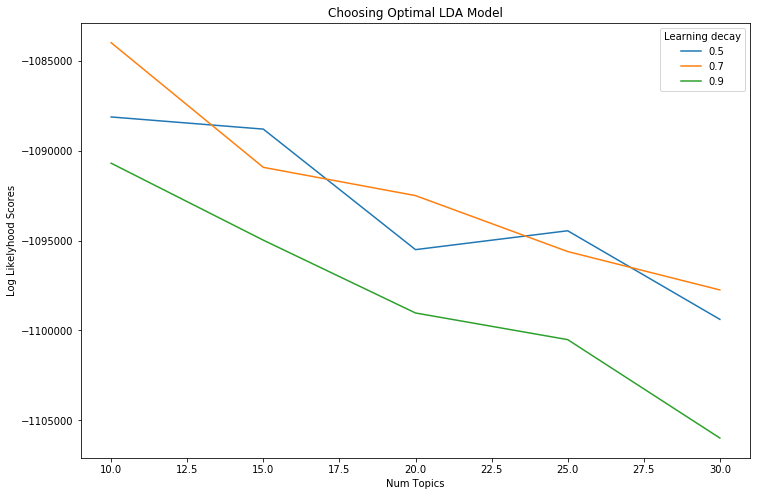

In [71]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## See Dominant Topic in Each Document

In [78]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
best_n_topics = 10
topicnames = ["Topic" + str(i) for i in range(best_n_topics)]

# topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0.07,0.6,0,0,0,0,0.32,0,0,2
Doc1,0,0.25,0.38,0,0,0,0,0.32,0.05,0,2
Doc2,0,0.25,0.19,0.15,0,0,0,0.29,0.11,0,7
Doc3,0,0.35,0.35,0,0,0,0,0.13,0.16,0.01,1
Doc4,0,0.35,0.35,0,0,0,0,0.13,0.16,0.01,1
Doc5,0,0.33,0.45,0,0,0,0,0.21,0,0,2
Doc6,0,0.37,0.3,0,0.07,0.1,0,0.16,0,0,1
Doc7,0,0.1,0.37,0.06,0.08,0,0,0.35,0.03,0,2
Doc8,0,0.37,0.3,0,0.07,0.1,0,0.16,0,0,1
Doc9,0,0,0.58,0,0,0.07,0,0.18,0,0.18,2


## Review Topic Distribution across Documents

In [79]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,632
1,1,545
2,5,484
3,7,426
4,9,381
5,0,281
6,8,189
7,2,161
8,4,129
9,6,86


## Visualize the LDA Model with pyLDAvis

In [85]:
# !pip install pyLDAvis
from pyLDAvis import sklearn as sk

In [86]:
pyLDAvis.enable_notebook()
panel = sk.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/stephen/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      22.963830        1       1  142.326797  101.020248
3      14.758679        1       2   92.402504   -9.620932
8      11.500040        1       3  -74.934158  207.701340
7      10.719392        1       4  -44.286060   -4.446561
0       9.329830        1       5   35.381134 -116.776764
5       9.149168        1       6 -181.878113  -10.099109
4       7.002163        1       7  -99.191559 -116.274834
9       6.503941        1       8    4.727245   95.371185
2       5.069038        1       9 -131.964752  100.548462
6       3.003919        1      10   59.639275  207.194595, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
350   Default  2968.000000         draft  2968.000000  30.0000  30.0000
806   Default  1876.000000       million  1876.000000  29.0000  29.0000
1346  Default  2380.000000         trade  2380.000000  28.0000  28.0000
852   Default   918.000000           nfl   918.000000  27.0000  27.0000
1340  Default  1170.000000    tournament  1170.000000  26.0000  26.0000
815   Default  1161.000000            mj  1161.000000  25.0000  25.0000
475   Default  1875.000000          free  1875.000000  24.0000  24.0000
639   Default  1562.000000          join  1562.000000  23.0000  23.0000
1102  Default  3273.000000         score  3273.000000  22.0000  22.0000
1113  Default  1441.000000          seed  1441.000000  21.0000  21.0000
271   Default  1177.000000      contract  1177.000000  20.0000  20.0000
1229  Default  1859.000000         state  1859.000000  19.0000  19.0000
163   Default   905.000000         brown   905.000000  18.0000  18.0000
1097  Default  2067.000000           say  2067.000000  17.0000  17.0000
312   Default  1626.000000          deal  1626.000000  16.0000  16.0000
843   Default   837.000000          ncaa   837.000000  15.0000  15.0000
571   Default  1772.000000          home  1772.000000  14.0000  14.0000
1266  Default  1438.000000        sunday  1438.000000  13.0000  13.0000
1264  Default  1068.000000        summer  1068.000000  12.0000  12.0000
148   Default  1364.000000         break  1364.000000  11.0000  11.0000
730   Default   805.000000         lonzo   805.000000  10.0000  10.0000
942   Default  2989.000000          pick  2989.000000   9.0000   9.0000
395   Default   710.000000            et   710.000000   8.0000   8.0000
836   Default  1332.000000           mvp  1332.000000   7.0000   7.0000
631   Default   856.000000        jersey   856.000000   6.0000   6.0000
1082  Default  1911.000000           run  1911.000000   5.0000   5.0000
928   Default  3252.000000       percent  3252.000000   4.0000   4.0000
1259  Default   853.000000         style   853.000000   3.0000   3.0000
664   Default   635.000000          kidd   635.000000   2.0000   2.0000
788   Default   723.000000          meek   723.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1380  Topic10    40.616436          uefa    41.524564   3.4831  -5.8787
950   Topic10   200.765410         pogba   205.657230   3.4812  -4.2807
351   Topic10   139.338770         drake   143.159982   3.4782  -4.6460
693   Topic10   316.240069            lb   340.281642   3.4320  -3.8264
1456  Topic10   213.733816          wnba   244.507756   3.3707  -4.2181
1459  Topic10   164.792359         woman   191.406831   3.3555  -4.4782
994   Topic10   195.598643          pure   232.752687   3.3313  -4.3068
852   Topic10   751.309694           nfl   918.817860   3.3040  -2.9611
647   Topic10   201.330797       journey   272.200582   3.2037  -4.2779
339   Topic10     3.793697      division     5.763825   3.0870  -8.2495
662   Topic10   183.194922          kick   336.152522   2.8982  -4.3723
163   Topic10   467.864313         brown   905.554142   2.8449  -3.4347
141   Topic10   173.2

### See Topic's Keywords

In [49]:
topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaron,abc,abilities,ability,able,absence,absolutely,absurd,abysmal,academy,...,younger,youngmisuk,youngsters,youth,youtube,zach,zaza,zero,zhaire,zone
Topic0,0.033343,0.033343,0.033344,0.033347,0.033343,0.033346,0.033342,0.033347,0.033344,0.033343,...,0.033343,0.033343,0.033343,0.033343,0.033342,0.033342,0.033344,0.033342,0.033346,0.033343
Topic1,0.033345,0.033344,0.033343,0.033344,0.033343,0.033343,0.033344,0.033343,0.033345,0.033343,...,0.033344,0.033343,0.033344,0.033342,0.033342,0.033344,0.033343,0.033343,0.033344,0.033344
Topic2,0.033349,0.033344,0.033347,0.033350,0.033345,0.033345,0.033344,0.033344,0.033342,0.033345,...,0.033345,0.033343,0.033344,0.033343,0.033343,0.033347,0.033342,0.033342,0.033356,0.033344
Topic3,0.033343,0.033346,0.033347,0.033347,0.033346,0.033347,0.033342,0.033346,0.033341,0.033343,...,0.033344,0.033342,0.033344,0.033345,0.033346,0.033346,0.033344,0.033347,0.033348,0.033343
Topic4,0.033342,0.033345,0.033342,0.033341,0.033343,0.033343,0.033344,0.033343,0.033343,0.033343,...,0.033343,0.033342,0.033344,0.033344,0.033342,0.033343,0.033345,0.033343,0.033343,0.033344


### Get 15 top keywords for each topic

In [58]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

NameError: name 'best_lda_model' is not defined

## Predict New Topics for New Piece of Text

In [ ]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

### Cluster Documents that share Similar Topics and Plot

In [ ]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

### Plot the Two SVD Components

In [ ]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [ ]:
## Get similar Documents
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)


# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

In [23]:
# texts = [[word for word in text.split() if word in vocab and word.isalpha()] for text in docs] # not tokenizing for now
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# %%time
# NUM_TOPICS = 30
# lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, update_every=1, chunksize=5000, passes=4)

CPU times: user 32 s, sys: 1.09 s, total: 33.1 s
Wall time: 33.4 s


In [117]:
# for i in range(NUM_TOPICS):
#     for word_id, p in lda.get_topic_terms(i):
#         print(dictionary[word_id],p, end=" ")
#     print("\n")

In [81]:
# for word_id, prob in lda.get_topic_terms(3)[:5]:
#     print(dictionary[word_id], prob, end=" ")
# print("\n")

million 0.024970928 trade 0.02018343 pick 0.016988372 free 0.014145047 deal 0.011659104 



In [94]:
# from collections import defaultdict
# topic2docs = defaultdict(list)
# for i,corpus_doc in enumerate(corpus):
#     topic_id = max(lda[corpus_doc], key=lambda x:x[1])[0]
#     topic2docs[topic_id].append(i)

## How I generated word2vec (a little out of place)

In [35]:
def clean(article, stem = False):
    words = nltk.word_tokenize(article)
#     words = [word for word in tokens if word.isalpha()]
    
    # convert everything to lower case
    words = [w.lower() for w in words]
        
    # split on caps
    words = [split_on_caps(w) for w in words]
    
    if stem:
        words = [porter.stem(word) for word in words]
        
    return " ".join(words).split()

docs_raw_filename = "docs_raw_saturday2"
with open (docs_raw_filename, 'rb') as fp:
    raw_docs = pickle.load(fp)
    
with open("data/coaches.txt", "r") as fp:
    coaches = [team.replace("\n", "").strip().lower() for team in fp.readlines()]
    
with open("data/teams.txt", "r") as fp:
    teams = [team.replace("\n", "").strip().lower() for team in fp.readlines()]
    
df = pd.read_csv("data/cities_teams.csv", header=None)

cities = [v.lower() for v in df[0].values]
team_names = [v.lower().strip() for v in df[1].values]

players_first_names, players_last_names = zip(*[p.split() for p in TOP_100_PLAYERS])

name_dict = {}
for p in TOP_100_PLAYERS:
    name_dict[p.split()[0]] = p
    name_dict[p.split()[1]] = p

name_dict["james"] = "lebron james"

docs_listed = [clean(article) for article in raw_docs]

In [36]:
docs_listed[0]

['the',
 'nba',
 'all-star',
 'game',
 'will',
 'have',
 'a',
 'much',
 'different',
 'look',
 'this',
 'year.the',
 'traditional',
 'eastern',
 'conference',
 'vs.',
 'western',
 'conference',
 'format',
 'has',
 'been',
 'scrapped',
 'in',
 'favor',
 'of',
 'a',
 'playground-style',
 'game',
 'in',
 'which',
 'two',
 'captains',
 'pick',
 'sides.those',
 'captains',
 'are',
 'golden',
 'state',
 'warriors',
 'point',
 'guard',
 'stephen',
 'curry',
 'and',
 'cleveland',
 'cavaliers',
 'forward',
 'lebron',
 'james',
 ',',
 'who',
 'were',
 'given',
 'a',
 'pool',
 'of',
 'players',
 'to',
 'choose',
 'from',
 'for',
 'their',
 'respective',
 'teams',
 '(',
 'named',
 'team',
 'stephen',
 'and',
 'team',
 'lebron',
 ')',
 '.first',
 ',',
 'james',
 'and',
 'curry',
 'each',
 'had',
 'to',
 'pick',
 'four',
 'players',
 'from',
 'a',
 'pool',
 'of',
 'eight',
 'contenders',
 'who',
 'were',
 'voted',
 'as',
 'starters',
 'prior',
 'to',
 'the',
 'draft',
 '.',
 'then',
 ',',
 'they',
 

In [ ]:
docs = [" ".join(article) for article in docs_listed]


def clean_doc(text):
    common = {"bron": "lebron_james", "kd": "kevin_durant", "steph": "stephen_curry", "russ": "russell_westbrook"}
    
    original_text = " ".join([word.lower() for word in text.split() if word.isalpha()])
    text = original_text # for modification
    
    for fn in players_first_names:
        wholename = name_dict[fn]
        if fn in text and wholename in original_text: # if first name and entire name is somewhere in text
            text = text.replace(wholename, "_".join(wholename.split())) # join wholename with underscore
            text = text.replace(" " + fn + " ", " " + "_".join(wholename.split()) + " ") #join the first name
    
    for ln in players_last_names:
        wholename = name_dict[ln]
        if ln in text and wholename in original_text: # if first name and entire name is somewhere in text
            text = text.replace(wholename, "_".join(wholename.split())) # join wholename with underscore
            text = text.replace(" " + ln + " ", " " + "_".join(wholename.split()) + " ") #join the first name

    for team in teams:
        if team in text:
            text = text.replace(" " + team + " ", " " + "_".join(team.split()) + " ")

    for city in cities:
        if city in text:
            text = text.replace(" " + city + " ", " " + "_".join(city.split()) + " ")

    for name in team_names:
        if name in text:
            text = text.replace(" " + name + " ", " " + "_".join(name.split()) + " ")
            
    for coach in coaches:
        last_name = coach.split()[1]
        if coach in text:
            text = text.replace(" " + coach + " ", " " + "_".join(coach.split()) + " ")
            text = text.replace(" " + last_name + " ", " " + "_".join(coach.split()) + " ")

    
    for acr, real in common.items():
        text = text.replace(" " + acr + " ", " " + real + " ")
    
    return text

docs = [clean_doc(doc) for doc in docs]

with open("docs_word2vec_saturday2", 'wb') as fp:
    pickle.dump(docs, fp)

In [31]:
from nltk import sent_tokenize #### rememeber this
d = [" ".join(article) for article in docs_listed]
s = sent_tokenize(d[0])

In [30]:
def clean_sentence(sentence):
    words = [word for word in word_tokenize(sentence) if word.isalpha()]
    # convert everything to lower case
    words = [w.lower() for w in words]

    # split on caps
    words = [split_on_caps(w) for w in words]

    return " ".join(words).split()

In [33]:
clean_sentence(s[0])

['the',
 'nba',
 'game',
 'will',
 'have',
 'a',
 'much',
 'different',
 'look',
 'this',
 'traditional',
 'eastern',
 'conference',
 'western',
 'conference',
 'format',
 'has',
 'been',
 'scrapped',
 'in',
 'favor',
 'of',
 'a',
 'game',
 'in',
 'which',
 'two',
 'captains',
 'pick',
 'captains',
 'are',
 'golden',
 'state',
 'warriors',
 'point',
 'guard',
 'stephen',
 'curry',
 'and',
 'cleveland',
 'cavaliers',
 'forward',
 'lebron',
 'james',
 'who',
 'were',
 'given',
 'a',
 'pool',
 'of',
 'players',
 'to',
 'choose',
 'from',
 'for',
 'their',
 'respective',
 'teams',
 'named',
 'team',
 'stephen',
 'and',
 'team',
 'lebron',
 'james',
 'and',
 'curry',
 'each',
 'had',
 'to',
 'pick',
 'four',
 'players',
 'from',
 'a',
 'pool',
 'of',
 'eight',
 'contenders',
 'who',
 'were',
 'voted',
 'as',
 'starters',
 'prior',
 'to',
 'the',
 'draft']